In [1]:
push!(LOAD_PATH, "../src")
using VariableHeightInvertedPendulum
using PyCall
using PyPlot
using Polynomials
using ForwardDiff
# using ODE

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
test = true
g = 9.8
x0 = -0.3
z0 = 1.
zd0 = 0.
zf = 1.
orbital_energies = test ? Dict("Eo_negative" => 0.) : Dict("Eo_negative" => -0.1, "Eo_zero" => 0., "Eo_positive" => 0.1);

In [3]:
function run_scenario(scenario::Scenario; kwargs...)
    filename = "/Users/twan/Documents/MIT/presentations/160606 dynamic walking/video/$(scenario.model.name)_$(scenario.name).mp4"
    sim_movie(scenario.model, scenario.initial_conditions, filename; test = test, kwargs...)
end

run_scenario (generic function with 1 method)

In [4]:
models = []
lipm = LIPM("lipm", g, zf)
push!(models, lipm)
# push!(models, PolynomialVariableHeightModel("slope", g, Poly([zf, 0.2])))
push!(models, PolynomialVariableHeightModel("variable_height", g, Poly([zf, 0.2, 0.5])));

scenarios = Scenario[]
for model in models
    for kv in orbital_energies
        scenario_name = first(kv)
        Eo = last(kv)
        xd0 = velocity_given_orbital_energy(model, x0, Eo)
        initial_conditions = [x0; xd0]
        scenario = Scenario(scenario_name, model, initial_conditions)
        push!(scenarios, scenario)
    end
end

In [5]:
function run_solved_trajectory(name, x0, z0, xd0, zd0; kwargs...)
    traj = zero_orbital_energy_trajectory(x0, z0, xd0, zd0, g, zf)
    trajectory_solved_model = PolynomialVariableHeightModel("trajectory_solved", g, traj)
    run_scenario(Scenario(name, trajectory_solved_model, [x0; xd0]); restrict_ztraj = true, kwargs...)
end

run_solved_trajectory (generic function with 1 method)

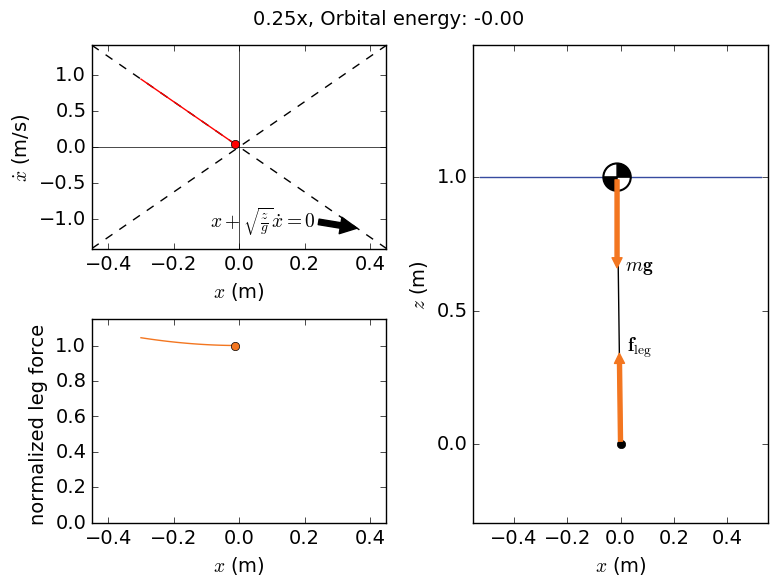

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x3197f1090>)

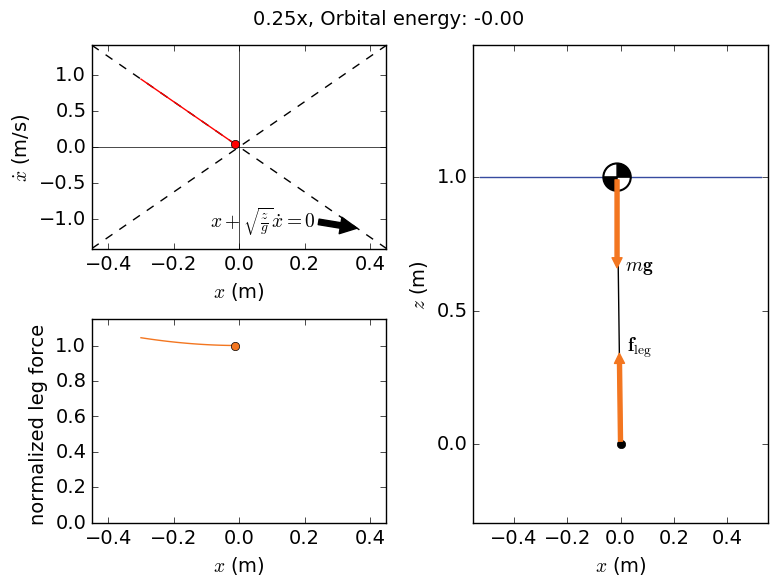

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x3197f1090>)

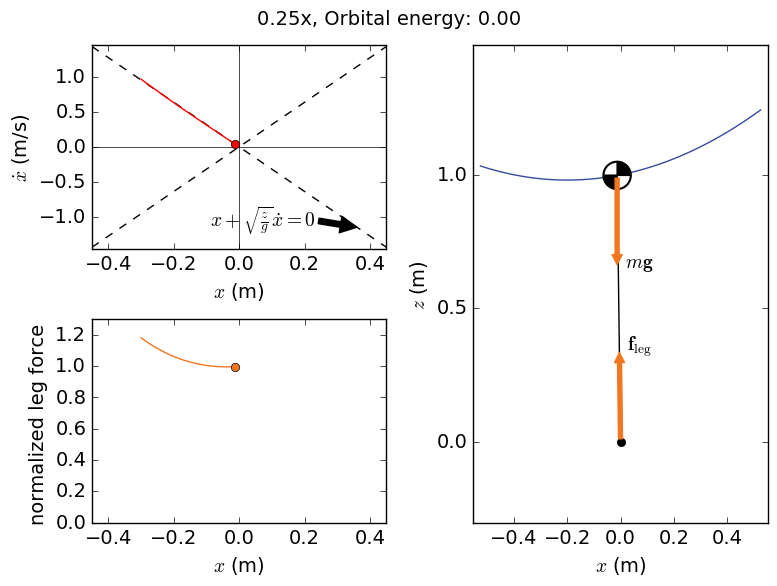

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31a181410>)

In [6]:
for scenario in scenarios
    run_scenario(scenario)
end

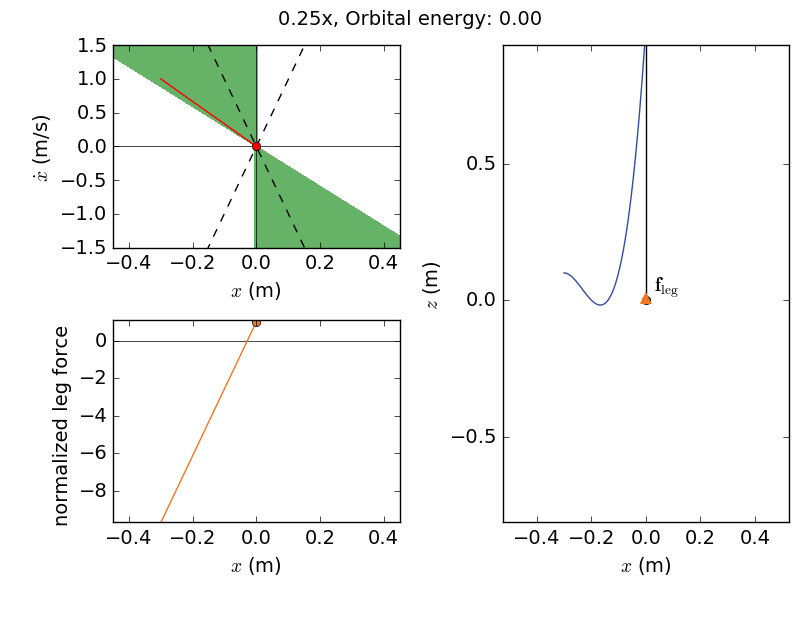

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31a1ce2d0>)

In [7]:
run_solved_trajectory("test", x0, 0.1, 1., zd0; show_region = true)

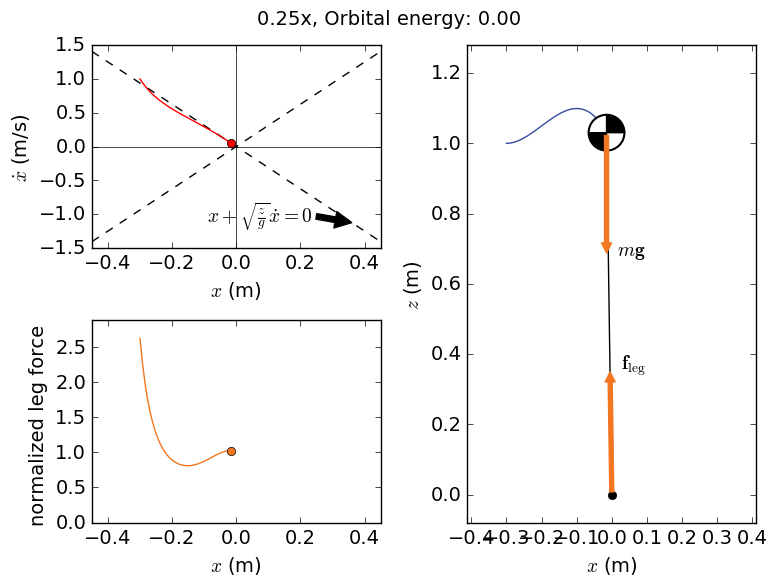

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31a7cb690>)

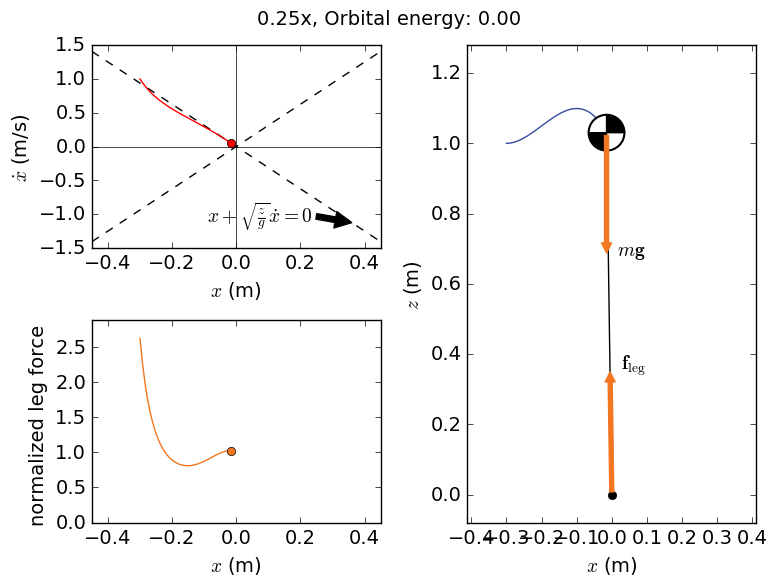

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31a7cb690>)

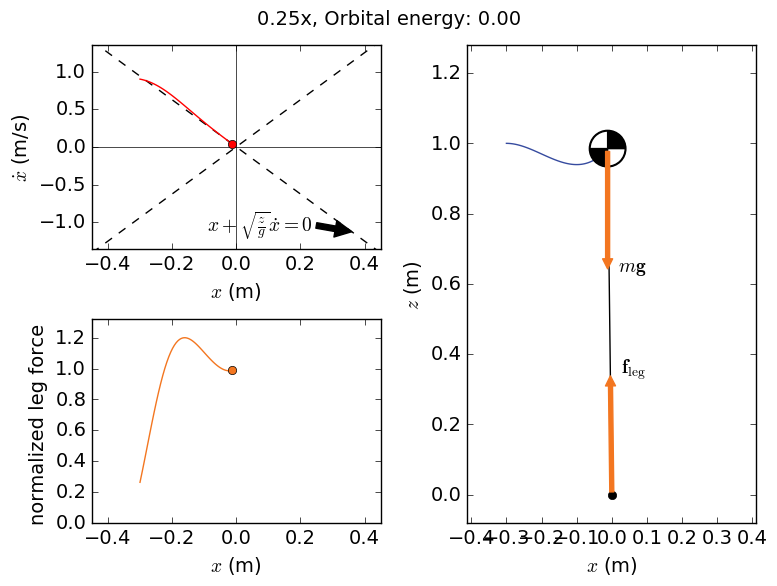

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31aa6fa50>)

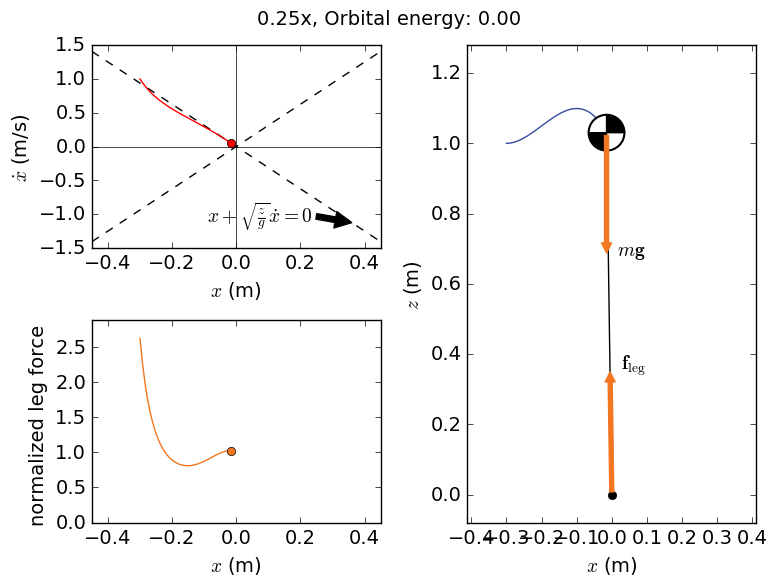

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31a7cb690>)

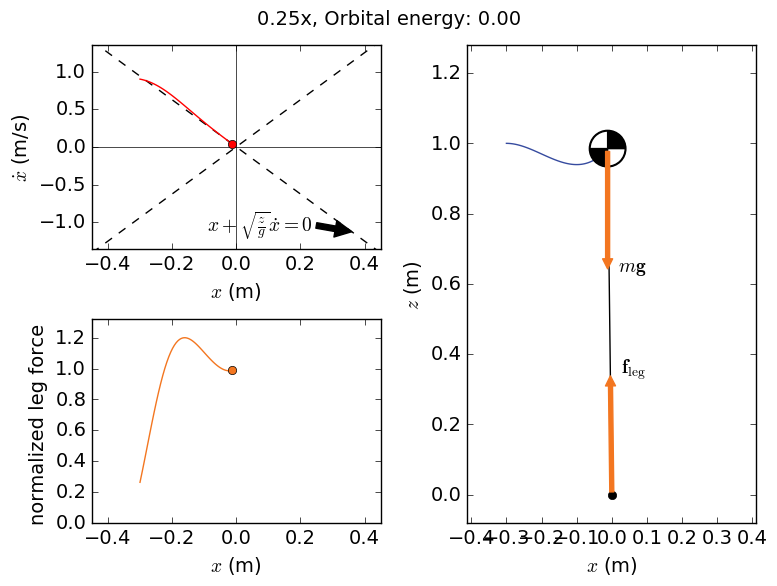

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31aa6fa50>)

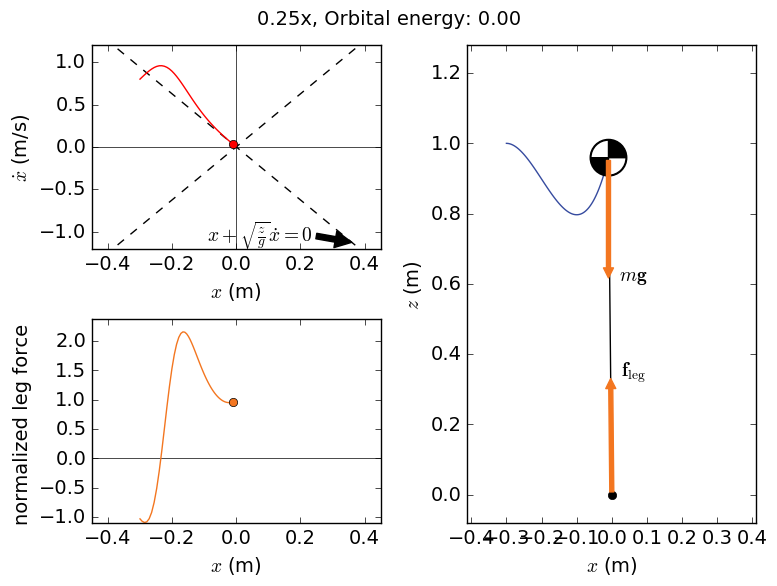

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x31af32f10>)

In [8]:
run_solved_trajectory("fast", x0, z0, 1., zd0)
run_solved_trajectory("slow", x0, z0, 0.9, zd0)
run_solved_trajectory("too_slow", x0, z0, 0.8, zd0)

In [8]:
run_solved_trajectory("too_fast", x0, z0, 1.3, zd0; simtime = 1.5)

In [9]:
run_solved_trajectory("fast_w_region", x0, z0, 1., zd0; show_region = true)
run_solved_trajectory("too_slow_w_region", x0, z0, 0.8, zd0; show_region = true)

In [14]:
# Variable height at same initial conditions that are too slow for LIPM
Eo = -0.04
xd0 = velocity_given_orbital_energy(lipm, x0, Eo)
kwargs = [(:model_only, true), (:simtime, 1.5), (:show_orbital_energy, false), (:stilltime, 1.), (:fig_size, (4., 3.))]
run_scenario(Scenario("comparison", lipm, [x0; xd0]); kwargs...)
run_solved_trajectory("comparison", x0, z0, xd0, zd0; kwargs...)

In [11]:
run_solved_trajectory("step_up", -0.5, 0.5, 2.5, 0.)

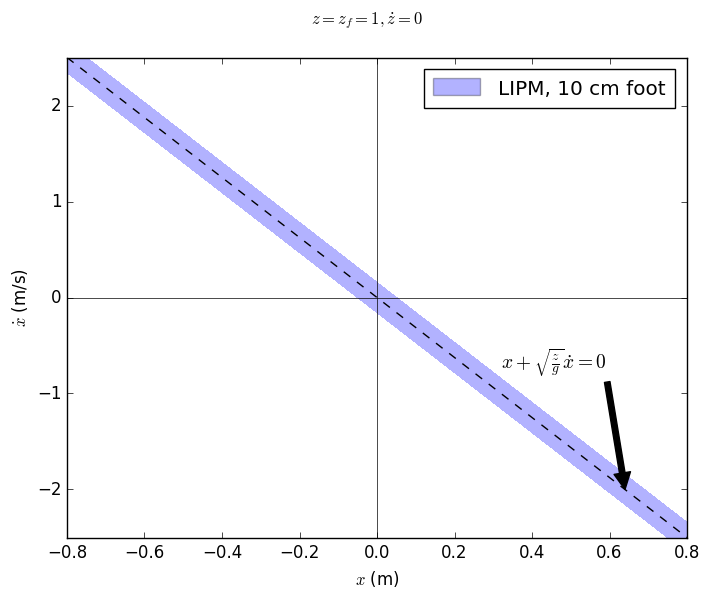

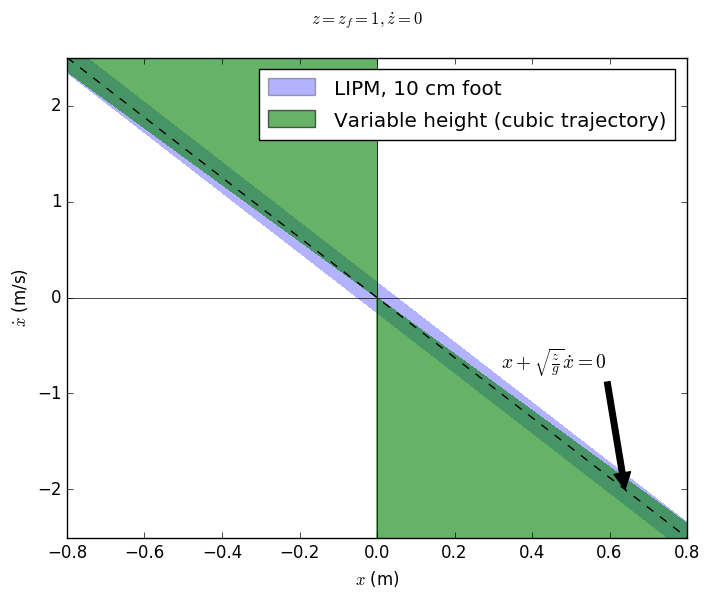

In [12]:
foot_size = 0.05
for show_variable_height in [false, true]
    font_size = 14
    plt[:rc]("font", size = font_size)
    lipm_color = "blue"
    lipm_alpha = 0.3
    variable_height_color = "g"
    variable_height_alpha = 0.6


    xrange = [-0.8, 0.8]
    xdrange = lipm.ω * xrange;
    num_points = 1000
    xlinspace = linspace(xrange..., num_points)
    xdlinspace = linspace(xdrange..., num_points)
    x_grid = [i::Float64 for i in xlinspace, j in xdlinspace]
    xd_grid = [j::Float64 for i in xlinspace, j in xdlinspace]
    xic_grid = abs(x_grid + 1 / lipm.ω * xd_grid)

    ion()
    fig = figure()
    xlim(xrange)
    ylim(xdrange)

    # axis lines
    axhline(linewidth = 0.5, color = "black")
    axvline(linewidth = 0.5, color = "black")

    # eigenvectors
    ω = lipm.ω
    # plot(xrange,  ω * xrange, "k--", linewidth = 1.0, zorder = 1)
    plot(xrange, -ω * xrange, "k--", linewidth = 1.0, zorder = 1)

    # ICP line annotation
    xarrowtip = xrange[2] - 0.1 * diff(xrange)
    arrowtip = [xarrowtip; -ω * xarrowtip]
    offset = [-diff(xrange) / 5; diff(xdrange) / 4]
    annotate(L"x + \sqrt{\frac{z}{g}} \dot{x} = 0", xy = arrowtip, xytext = arrowtip + offset, xycoords="data", arrowprops = Dict("facecolor"=>"black"))


    # axis labels
    xlabel(L"x" * " (m)")
    ylabel(L"\dot x" * " (m/s)")

    lipm_contour = contourf(x_grid, xd_grid, xic_grid, levels = [-Inf, foot_size], colors = lipm_color, alpha = lipm_alpha, zorder = 1)[:collections][1]
    lipm_proxy = plt[:Rectangle]((0,0),1,1, fc = lipm_color, alpha = lipm_alpha)

    if show_variable_height
        opposite_velocity_mask = max(-sign((x_grid .* xd_grid)), 0)
        valid = VariableHeightInvertedPendulum.is_force_always_nonnegative_condition2(lipm.g, x_grid, zf, xd_grid, 0., zf) .* opposite_velocity_mask
        invalidcontour = contourf(x_grid, xd_grid, valid, levels = [0, Inf], colors = variable_height_color, alpha = variable_height_alpha, zorder = 1)
        variable_height_proxy = plt[:Rectangle]((0,0),1,1, fc = variable_height_color, alpha = variable_height_alpha)
    end

    if show_variable_height
        legend([lipm_proxy, variable_height_proxy], ["LIPM, 10 cm foot", "Variable height (cubic trajectory)"])
    else
        legend([lipm_proxy], ["LIPM, 10 cm foot"])
    end

    suptitle(L"z = z_f = 1, \dot{z} = 0")
    savefig("/Users/twan/Documents/MIT/presentations/160606 dynamic walking/figures/ss_variable_height_$(show_variable_height).pdf")

    plt[:rcdefaults]()
end